This is a test live run of three base models namely 
1. Long OLMAR (w = 5, epsilon = 10) 
2. Long ONS (eta = 0, beta = 1, delta = 1/8) 
3. Cash Agent  

With a moving geometric mean model selector with window size equal to 20. 

Both the above hyperparameter configurations for OLMAR and ONS are the ones presented in the paper

In [2]:
import numpy as np 
import pandas as pd 
import random 
import os 
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from tqdm import tqdm
import pyupbit
import time

# Define OLMAR Model

In [3]:
# Simplex Projection
def simplex_proj(y):
    """ Projection of y onto simplex. """
    m = len(y)
    bget = False

    s = sorted(y, reverse=True)
    tmpsum = 0.

    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1);
        if tmax >= s[ii+1]:
            bget = True
            break

    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m

    y = np.asarray(y)

    return np.maximum(y-tmax,0.)

In [4]:
# w is the window size
# r is the rebalancing period in hours
def get_predicted_return(ticker, w=5, r=10):
    df = pyupbit.get_ohlcv(ticker, interval="minute60")
    close = df['close'].values
    close = close[-1::-r] # get every 10th
    ma_prediction = 0
    for i in range(w):
        ma_prediction += close[i]
    ma_prediction *= (1/close[0]) * (1/w)
    return ma_prediction

In [5]:
def OLMAR(current_portfolio, predicted_returns, epsilon=10):
    avg_x = np.sum([x*y for x,y in zip([1 for i in predicted_returns], predicted_returns)])
    avg_x *= 1.0 / float(len(predicted_returns))
    # numerator
    temp_top = epsilon - sum([x*y for x,y in zip(current_portfolio, predicted_returns)])
    # denominator
    temp_bottom1 = np.array(predicted_returns)
    temp_bottom2 = np.array([avg_x for i in predicted_returns])
    dist = np.sum(np.power((temp_bottom1 - temp_bottom2), 2))
    lambda_1 = max(0.0, temp_top/dist)
    # update portfolio
    np_current_portfolio = np.array(current_portfolio)
    new_portfolio = np_current_portfolio + lambda_1 * (temp_bottom1 - temp_bottom2)
    new_portfolio = simplex_proj(new_portfolio.tolist())
    return new_portfolio 

# Define ONS Model

In [6]:
def projection_in_norm(x,M): 
    """Projection of x to simplex indiced by matrix M. Uses quadratic programming."""
    m = M.shape[0]

    P = matrix(2 * M)
    q = matrix(-2 * M * x)
    G = matrix(-np.eye(m))
    h = matrix(np.zeros((m, 1)))
    A = matrix(np.ones((1, m)))
    b = matrix(1.0)
    
    solvers.options["show_progress"] = False
    sol = solvers.qp(P, q, G, h, A, b)
    return np.squeeze(sol["x"]) 

In [7]:
# r is the rebalancing period in hours
def get_current_returns(ticker, r=10):
    df = pyupbit.get_ohlcv(ticker, interval="minute60")
    close = df['close'].values
    close = close[-1::-r] # get every 10th 
    returns = close[0] / close[1] # r_t(j) = p_t(j) / p_{t-1}(j)  
    return returns 

In [8]:
# current_portfolio: p in the paper 
# current_returns: r in the paper 
def ONS(current_portfolio, current_returns, A, b, delta=0.125, beta=1.0, eta=0.0):
    # calculate gradient 
    grad = np.mat(current_returns / np.dot(current_portfolio, current_returns)).T
    # update A 
    A += grad * grad.T
    # update b 
    b += (1 + 1.0 / beta) * grad 
    # projection of p induced by norm A 
    pp = projection_in_norm(delta * A.I * b, A)
    return pp * (1 - eta) + np.ones(len(current_returns)) / float(len(current_returns)) * eta
    

In [9]:
m = 6
A = np.mat(np.eye(m))
b = np.mat(np.zeros(m)).T
current_portfolio = np.ones(m) / m
tickers = ["KRW-BTC", "KRW-ADA", "KRW-DOGE", "KRW-XRP", "KRW-ETH", "KRW-DOT"]
current_returns = [get_current_returns(ticker) for ticker in tqdm(tickers)] 

new_portfolio = ONS(current_portfolio, current_returns, A, b) 

print(new_portfolio) 


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

[0.17242924 0.16084034 0.16687358 0.16687358 0.17170991 0.16127335]


# Define Cash Agent

In [9]:
cash_agent = [0.0 for i in range(m)] 
cash_agent

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Perform Backtest

In [44]:
btc = pd.read_json('BTC_USDT-1h.json') 
eth = pd.read_json('ETH_USDT-1h.json') 
dot = pd.read_json('DOT_USDT-1h.json') 
doge = pd.read_json('DOGE_USDT-1h.json') 
xrp = pd.read_json('XRP_USDT-1h.json') 
ada = pd.read_json('ADA_USDT-1h.json') 

In [45]:
btc.shape, eth.shape, dot.shape, doge.shape, xrp.shape, ada.shape

((5497, 6), (5497, 6), (5497, 6), (5497, 6), (5497, 6), (5497, 6))

In [46]:
btc.tail()

,0,1,2,3,4,5
5492,1629270000000,45395.90,45436.57,44853.80,44951.32,1795.908700
5493,1629273600000,44951.31,45279.92,44859.55,45251.83,1473.581870
5494,1629277200000,45251.82,45462.71,45122.01,45373.42,1727.680646
5495,1629280800000,45373.42,45560.00,45108.03,45180.35,1718.812472
5496,1629284400000,45180.35,45421.02,44650.00,44746.59,2640.739966


In [47]:
btc_close = btc.iloc[:,4].values 
eth_close = eth.iloc[:,4].values
dot_close = dot.iloc[:,4].values 
doge_close = doge.iloc[:,4].values 
xrp_close = xrp.iloc[:,4].values 
ada_close = ada.iloc[:,4].values 

In [48]:
def format_data(price_data, r=10): 
    return price_data[::r]

In [49]:
# get data for every 10 hours 
btc_close = format_data(btc_close) 
eth_close = format_data(eth_close) 
dot_close = format_data(dot_close) 
doge_close = format_data(doge_close) 
xrp_close = format_data(xrp_close)
ada_close = format_data(ada_close) 

In [50]:
price_data = np.concatenate([btc_close.reshape((-1,1)), 
                             eth_close.reshape((-1,1)), 
                             dot_close.reshape((-1,1)), 
                             xrp_close.reshape((-1,1)),
                             doge_close.reshape((-1,1)), 
                             ada_close.reshape((-1,1))], axis = 1) 
price_data.shape

(550, 6)

In [51]:
# compute geometric mean of array x 
def geometric_mean(x):
    x = np.asarray(x) 
    return x.prod() ** (1/len(x)) 

In [52]:
# compute arithmetic mean of array x 
def arithmetic_mean(x):  
    x = np.asarray(x) 
    return np.mean(x) 

# ONS Backtest

In [53]:
w = 5 
m = 6 
model_selector_w = 20 
tickers = ["BTC", "ETH", "DOT", "XRP", "DOGE", "ADA"] 
A = np.mat(np.eye(m))
b = np.mat(np.zeros(m)).T

olmar_current_portfolio = [1/m for _ in range(m)]  
ons_current_portfolio = [1/m for _ in range(m)] 
cash_agent_current_portfolio = [0 for _ in range(m)] 

OLMAR_history = [] 
CASH_AGENT_history = [] 
ONS_history = [] 

ONS_cnt = 0 
OLMAR_cnt = 0 
CASH_AGENT_cnt = 0 

cumulative_wealth = 1.0 

choice = 0 

gamma = 0.05 

init_seed = 1000 
cash = 1000 
cash_status = [] 

for i in tqdm(range(w, price_data.shape[0])):
    
    if i > w: 
        # sell 
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret) 
        cash = np.sum([ons_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        cash_status.append(cash)
    
    current_returns = [] 
    for j in range(m):  
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret) 
        
    ons_current_portfolio = ONS(ons_current_portfolio, current_returns, A, b) 
    
    # buy 
    cash = np.sum([ons_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])
    
    
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))
    

100%|██████████| 545/545 [00:00<00:00, 684.39it/s]

final cash amount = $2438.15
percentage profit = 143.81%


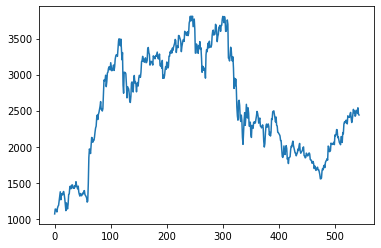

In [54]:
plt.plot(cash_status)

# OLMAR Backtest

In [55]:
w = 5 
m = 6 
model_selector_w = 20 
tickers = ["BTC", "ETH", "DOT", "XRP", "DOGE", "ADA"] 
A = np.mat(np.eye(m))
b = np.mat(np.zeros(m)).T

olmar_current_portfolio = [1/m for _ in range(m)]  
ons_current_portfolio = [1/m for _ in range(m)] 
cash_agent_current_portfolio = [0 for _ in range(m)] 

OLMAR_history = [] 
CASH_AGENT_history = [] 
ONS_history = [] 

ONS_cnt = 0 
OLMAR_cnt = 0 
CASH_AGENT_cnt = 0 

cumulative_wealth = 1.0 

choice = 0 

gamma = 0.05 

init_seed = 1000 
cash = 1000
cash_status = [] 

for i in tqdm(range(w, price_data.shape[0])):
    
    if i > w: 
        # sell 
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret) 
        cash = np.sum([olmar_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        cash_status.append(cash)
    
    predicted_returns = [] 
    for j in range(m):  
        moving_avg = 0 
        for k in range(i-w+1, i+1):
            moving_avg += price_data[k,j] 
        moving_avg *= (1/w) * (1/price_data[i,j])
        predicted_returns.append(moving_avg) 
    olmar_current_portfolio = OLMAR(olmar_current_portfolio, predicted_returns)  
    
    # buy 
    cash = np.sum([olmar_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])
    
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))




100%|██████████| 545/545 [00:00<00:00, 7411.73it/s]

final cash amount = $2497.68
percentage profit = 149.77%


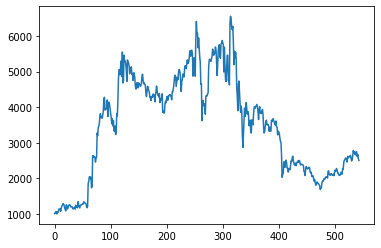

In [56]:
plt.plot(cash_status)

# BTC BAH

In [57]:
btc_ret = price_data[-1,0] / price_data[0,0]
bah_amount = 1000*(1-gamma/1000)*btc_ret 
print("BAH bitcoin cash amount = ${:.2f}".format(bah_amount)) 
print("BAH bitcoin percentage profit = {:.2f}%".format((bah_amount-init_seed)/init_seed * 100))

BAH bitcoin cash amount = $1567.08
BAH bitcoin percentage profit = 56.71%


# Uniform CRP

In [58]:
m = 6
model_selector_w = 20 
tickers = ["BTC", "ETH", "DOT", "XRP", "DOGE", "ADA"] 

crp = [1/m for _ in range(m)] 

gamma = 0.05 

init_seed = 1000 
cash = 1000 

cash_status = [] 

for i in tqdm(range(w, price_data.shape[0])): 
    if i > w: 
        # sell 
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret) 
        cash = np.sum([crp[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        
        cash_status.append(cash)
    
        
    # buy 
    cash = np.sum([crp[j]*cash*(1-gamma/100) for j in range(m)])
    
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))

    


100%|██████████| 545/545 [00:00<00:00, 34192.87it/s]

final cash amount = $4952.22
percentage profit = 395.22%


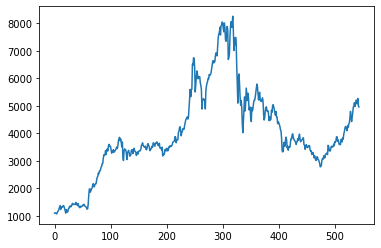

In [59]:
plt.plot(cash_status)

# ONS, OLMAR, CASH AGENT with model selector

In [90]:
w = 5 
m = 6 
model_selector_w = 26
tickers = ["BTC", "ETH", "DOT", "XRP", "DOGE", "ADA"] 

A = np.mat(np.eye(m))
b = np.mat(np.zeros(m)).T

olmar_current_portfolio = [1/m for _ in range(m)]  
ons_current_portfolio = [1/m for _ in range(m)] 
cash_agent_current_portfolio = [0 for _ in range(m)] 

olmar_history = [] 
cash_agent_history = [] 
ons_history = [] 

ons_cnt = 0 
olmar_cnt = 0 
cash_agent_cnt = 0 

cumulative_wealth = 1.0 

# which model did we choose?  
choice = 0 

gamma = 0.05 

init_seed = 1000 
cash = 1000 
cash_status = [] 

for i in tqdm(range(w, price_data.shape[0])):
    
    if i > w: 
        # sell 
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret) 
            
        if choice == 0: 
            ons_cnt += 1 
            cash = np.sum([ons_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)])
        elif choice == 1: 
            olmar_cnt += 1 
            cash = np.sum([olmar_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        elif choice == 2: 
            cash_agent_cnt += 1 
            pass # no change in cash 
        
        cash_status.append(cash)
        
        # populate history arrays 
        ons_returns = np.sum([x*y for x,y in zip(ons_current_portfolio, current_returns)]) 
        olmar_returns = np.sum([x*y for x,y in zip(olmar_current_portfolio, current_returns)]) 
        cash_agent_returns = 0.0 
        
        ons_history.append(ons_returns)
        olmar_history.append(olmar_returns)
        cash_agent_history.append(cash_agent_returns) 
        
        # sliding window effect  
        if len(ons_history) > model_selector_w: 
            ons_history.pop(0) 
        if len(olmar_history) > model_selector_w:  
            olmar_history.pop(0) 
        if len(cash_agent_history) > model_selector_w: 
            cash_agent_history.pop(0) 
            
    
    # calculate ons portfolio 
    current_returns = [] 
    for j in range(m):  
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret) 
    ons_current_portfolio = ONS(ons_current_portfolio, current_returns, A, b) 
    
    # calculate olmar portfolio 
    predicted_returns = [] 
    for j in range(m):  
        moving_avg = 0 
        for k in range(i-w+1, i+1):
            moving_avg += price_data[k,j] 
        moving_avg *= (1/w) * (1/price_data[i,j])
        predicted_returns.append(moving_avg) 
    olmar_current_portfolio = OLMAR(olmar_current_portfolio, predicted_returns)   
    
    
    if len(olmar_history) == 0: 
        # this must be our first iteration 
        # choose either olmar or ons or cash agent
        choice = np.random.choice(3, 1, p=[1/3,1/3,1/3]) 
        if choice == 0: 
            cash = np.sum([ons_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
        elif choice == 1: 
            cash = np.sum([olmar_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])  
        elif choice == 2: 
            pass 
    else: 
        olmar_profits = geometric_mean(olmar_history) 
        ons_profits = geometric_mean(ons_history) 
        if ons_profits >= olmar_profits and ons_profits > 1: 
            choice = 0 
            cash = np.sum([ons_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])  
        elif olmar_profits >= ons_profits and olmar_profits > 1:  
            choice = 1 
            cash = np.sum([olmar_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])
        else: 
            # it is probably a down market 
            choice = 2 
            # no change to cash 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))
    

100%|██████████| 545/545 [00:00<00:00, 594.75it/s]

final cash amount = $1977.02
percentage profit = 97.70%


In [83]:
ons_cnt, olmar_cnt, cash_agent_cnt

(195, 195, 154)

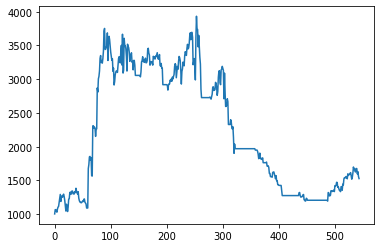

In [84]:
plt.plot(cash_status)

# ONS, OLMAR, CASH AGENT, Uniform CRP with model selector

In [68]:
w = 5 
m = 6 
model_selector_w = 30 
tickers = ["BTC", "ETH", "DOT", "XRP", "DOGE", "ADA"] 

A = np.mat(np.eye(m))
b = np.mat(np.zeros(m)).T

olmar_current_portfolio = [1/m for _ in range(m)]  
ons_current_portfolio = [1/m for _ in range(m)] 
cash_agent_current_portfolio = [0 for _ in range(m)] 
crp_current_portfolio = [1/m for _ in range(m)]  

olmar_history = [] 
cash_agent_history = [] 
ons_history = [] 
crp_history = []

ons_cnt = 0 
olmar_cnt = 0 
cash_agent_cnt = 0 
crp_cnt = 0 

cumulative_wealth = 1.0 

# which model did we choose?  
choice = 0 

gamma = 0.05 

init_seed = 1000 
cash = 1000 
cash_status = [] 

for i in tqdm(range(w, price_data.shape[0])):
    
    if i > w: 
        # sell 
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret) 
            
        if choice == 0: 
            ons_cnt += 1 
            cash = np.sum([ons_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)])
        elif choice == 1: 
            olmar_cnt += 1 
            cash = np.sum([olmar_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        elif choice == 2: 
            cash_agent_cnt += 1 
            pass # no change in cash  
        elif choice == 3: 
            crp_cnt += 1 
            cash = np.sum([crp_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
            
        cash_status.append(cash)
        
        # populate history arrays 
        ons_returns = np.sum([x*y for x,y in zip(ons_current_portfolio, current_returns)]) 
        olmar_returns = np.sum([x*y for x,y in zip(olmar_current_portfolio, current_returns)]) 
        cash_agent_returns = 0.0 
        crp_returns = np.sum([x*y for x,y in zip(crp_current_portfolio, current_returns)])
        
        ons_history.append(ons_returns)
        olmar_history.append(olmar_returns)
        cash_agent_history.append(cash_agent_returns) 
        crp_history.append(crp_returns)
        
        # sliding window effect  
        if len(ons_history) > model_selector_w: 
            ons_history.pop(0) 
        if len(olmar_history) > model_selector_w:  
            olmar_history.pop(0) 
        if len(cash_agent_history) > model_selector_w: 
            cash_agent_history.pop(0)  
        if len(crp_history) > model_selector_w: 
            crp_history.pop(0)
            
    
    # calculate ons portfolio 
    current_returns = [] 
    for j in range(m):  
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret) 
    ons_current_portfolio = ONS(ons_current_portfolio, current_returns, A, b) 
    
    # calculate olmar portfolio 
    predicted_returns = [] 
    for j in range(m):  
        moving_avg = 0 
        for k in range(i-w+1, i+1):
            moving_avg += price_data[k,j] 
        moving_avg *= (1/w) * (1/price_data[i,j])
        predicted_returns.append(moving_avg) 
    olmar_current_portfolio = OLMAR(olmar_current_portfolio, predicted_returns)   
    
    
    if len(olmar_history) == 0: 
        # this must be our first iteration 
        # choose either olmar or ons or cash agent
        choice = np.random.choice(4, 1, p=[1/4,1/4,1/4,1/4]) 
        if choice == 0: 
            cash = np.sum([ons_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
        elif choice == 1: 
            cash = np.sum([olmar_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])  
        elif choice == 2: 
            pass 
        elif choice == 3: 
            cash = np.sum([crp_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])  
    else: 
        olmar_profits = geometric_mean(olmar_history) 
        ons_profits = geometric_mean(ons_history)  
        crp_profits = geometric_mean(crp_history) 
        
        
        if ons_profits >= olmar_profits and ons_profits >= crp_profits and ons_profits > 1: 
            choice = 0 
            cash = np.sum([ons_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])  
        elif olmar_profits >= ons_profits and olmar_profits >= crp_profits and olmar_profits > 1:  
            choice = 1 
            cash = np.sum([olmar_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
        elif crp_profits >= ons_profits and crp_profits >= olmar_profits and crp_profits > 1:  
            choice = 3 
            cash = np.sum([crp_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])
        else: 
            # it is probably a down market 
            choice = 2 
            # no change to cash 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))
    

100%|██████████| 545/545 [00:00<00:00, 588.84it/s]

final cash amount = $5229.96
percentage profit = 423.00%


In [69]:
olmar_cnt, ons_cnt, crp_cnt, cash_agent_cnt

(101, 134, 175, 134)

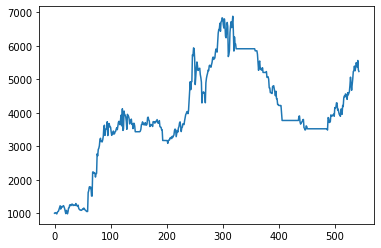

In [70]:
plt.plot(cash_status)

# ONS, OLMAR, CASH AGENT, Uniform CRP with model selector with no initial random choice

In [71]:
w = 5 
m = 6 
model_selector_w = 30
tickers = ["BTC", "ETH", "DOT", "XRP", "DOGE", "ADA"] 

A = np.mat(np.eye(m))
b = np.mat(np.zeros(m)).T

olmar_current_portfolio = [1/m for _ in range(m)]  
ons_current_portfolio = [1/m for _ in range(m)] 
cash_agent_current_portfolio = [0 for _ in range(m)] 
crp_current_portfolio = [1/m for _ in range(m)]  

olmar_history = [] 
cash_agent_history = [] 
ons_history = [] 
crp_history = []

ons_cnt = 0 
olmar_cnt = 0 
cash_agent_cnt = 0 
crp_cnt = 0 

cumulative_wealth = 1.0 

# which model did we choose?  
choice = 0 

gamma = 0.05 

init_seed = 1000 
cash = 1000 
cash_status = [] 

for i in tqdm(range(w, price_data.shape[0])):
    
    if i > w: 
        # sell 
        current_returns = []
        for j in range(m): 
            ret = price_data[i,j] / price_data[i-1,j] 
            current_returns.append(ret) 
            
        if choice == 0: 
            ons_cnt += 1 
            cash = np.sum([ons_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)])
        elif choice == 1: 
            olmar_cnt += 1 
            cash = np.sum([olmar_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
        elif choice == 2: 
            cash_agent_cnt += 1 
            pass # no change in cash  
        elif choice == 3: 
            crp_cnt += 1 
            cash = np.sum([crp_current_portfolio[j]*cash*current_returns[j]*(1-gamma/100) for j in range(m)]) 
            
        cash_status.append(cash)
        
        # populate history arrays 
        ons_returns = np.sum([x*y for x,y in zip(ons_current_portfolio, current_returns)]) 
        olmar_returns = np.sum([x*y for x,y in zip(olmar_current_portfolio, current_returns)]) 
        cash_agent_returns = 0.0 
        crp_returns = np.sum([x*y for x,y in zip(crp_current_portfolio, current_returns)])
        
        ons_history.append(ons_returns)
        olmar_history.append(olmar_returns)
        cash_agent_history.append(cash_agent_returns) 
        crp_history.append(crp_returns)
        
        # sliding window effect  
        if len(ons_history) > model_selector_w: 
            ons_history.pop(0) 
        if len(olmar_history) > model_selector_w:  
            olmar_history.pop(0) 
        if len(cash_agent_history) > model_selector_w: 
            cash_agent_history.pop(0)  
        if len(crp_history) > model_selector_w: 
            crp_history.pop(0)
            
    
    # calculate ons portfolio 
    current_returns = [] 
    for j in range(m):  
        ret = price_data[i,j] / price_data[i-1,j] 
        current_returns.append(ret) 
    ons_current_portfolio = ONS(ons_current_portfolio, current_returns, A, b) 
    
    # calculate olmar portfolio 
    predicted_returns = [] 
    for j in range(m):  
        moving_avg = 0 
        for k in range(i-w+1, i+1):
            moving_avg += price_data[k,j] 
        moving_avg *= (1/w) * (1/price_data[i,j])
        predicted_returns.append(moving_avg) 
    olmar_current_portfolio = OLMAR(olmar_current_portfolio, predicted_returns)   
    
    
    if len(olmar_history) == 0: 
        # this must be our first iteration 
        # choose uniform CRP 
        choice = 3 
        cash = np.sum([crp_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])   
    else: 
        olmar_profits = geometric_mean(olmar_history) 
        ons_profits = geometric_mean(ons_history)  
        crp_profits = geometric_mean(crp_history) 
        
        if ons_profits >= olmar_profits and ons_profits >= crp_profits and ons_profits > 1: 
            choice = 0 
            cash = np.sum([ons_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])  
        elif olmar_profits >= ons_profits and olmar_profits >= crp_profits and olmar_profits > 1:  
            choice = 1 
            cash = np.sum([olmar_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)]) 
        elif crp_profits >= ons_profits and crp_profits >= olmar_profits and crp_profits > 1:  
            choice = 3 
            cash = np.sum([crp_current_portfolio[j]*cash*(1-gamma/100) for j in range(m)])
        else: 
            # it is probably a down market 
            choice = 2 
            # no change to cash 
    
        
print("final cash amount = ${:.2f}".format(cash)) 
print("percentage profit = {:.2f}%".format((cash-init_seed)/init_seed * 100))
    

100%|██████████| 545/545 [00:01<00:00, 508.01it/s]

final cash amount = $5678.18
percentage profit = 467.82%


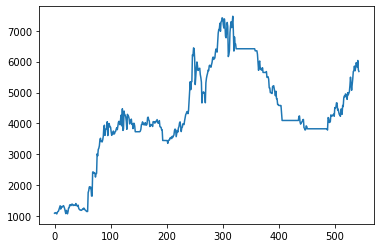

In [73]:
plt.plot(cash_status)